# Toxic_Language Naive Bayes
## Machine Learning Course Project
---
### Author: Naoya Kumakura
### Date: June 2025
---
## Data: 
Dataset is derived from comments written by Wikipedia contributors. Alongside a
majority of regular (“ok”) messages, you can find a variety of negative comments. A
sample of these has been collected and manually classified as:
- ‘ok’;
- ‘hate’;
- ‘insult’;
- ‘obscene’;
- ‘toxic’;
- ‘threat’.

28,000 training comments, divided in 
4,000 test comments

The data are stored in text files, with one headline for each line.


## Goal:
- Build classifiers for the detection of the 6 types of class label. We need to onsider two scenarios: accuracy oriented and fpr oriented.
- to be more concrete, I implement Multinomial Naive Bayes (Considering the number of apperance) for 2 class('ok' and 'not ok') and multi class ('ok','hate', 'insult', 'obscene', 'toxic', 'threat')


---

```

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import string
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import random

# choose what ever you want(size of vocabulary / multi class or 2 class )
vocab_size = 1000
multi_class = False
TF_IDF_IS = False

# do not change here
if (multi_class==True):
    num_classes = 6
else:
    num_classes = 2

### 1 - **DATA ANALYSIS**
loading The test.csv and train.csv and counting the number of each classes.
The graph below shows umbalance of the number of classes. 

/home/naoya/pv2/machinelearning/lastassignment/Offensive_Message_Classification
Train label distribution:
Counter({'ok': 13780, 'insult': 5693, 'toxic': 4983, 'obscene': 1973, 'hate': 1153, 'threat': 418})
Test label distribution:
Counter({'ok': 1995, 'insult': 807, 'toxic': 724, 'obscene': 260, 'hate': 154, 'threat': 60})


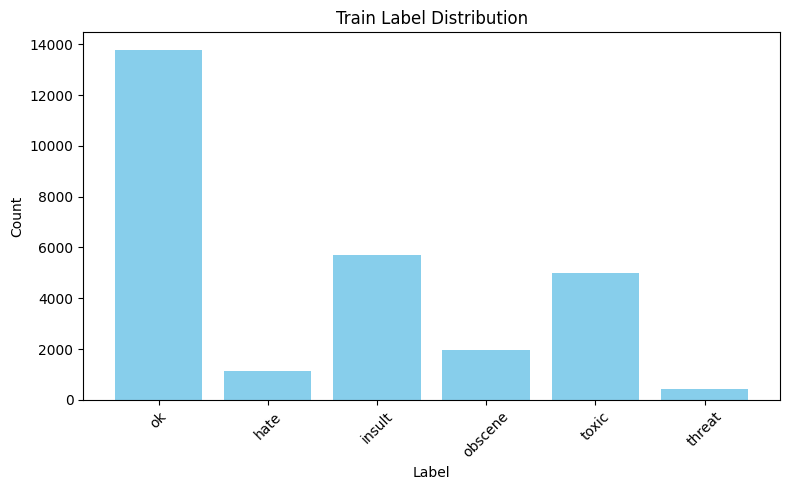

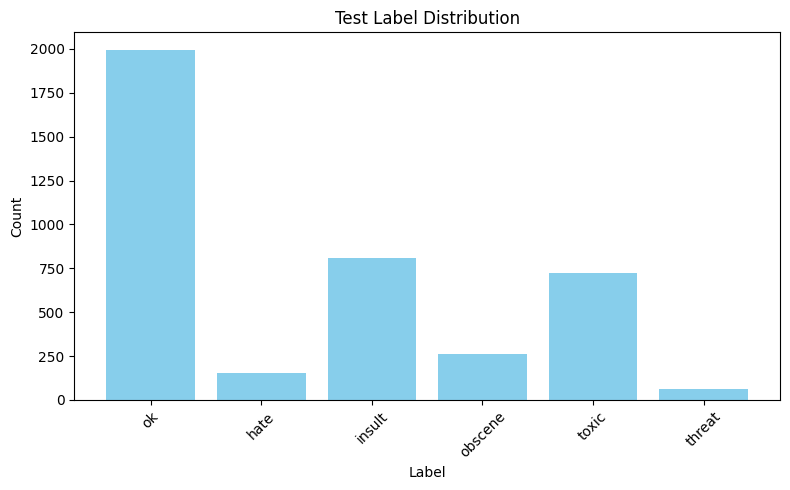

In [15]:
def read_labels_from_csv(filepath):
    labels = []
    with open(filepath, encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            labels.append(row['label'].strip())
    return np.array(labels)

def plot_label_distribution(labels, title, filename):
    label_counts = Counter(labels)
    # 表示順を固定
    order = ['ok', 'hate', 'insult', 'obscene', 'toxic', 'threat']
    counts = [label_counts.get(label, 0) for label in order]

    plt.figure(figsize=(8, 5))
    plt.bar(order, counts, color='skyblue')
    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

def main():
    train_labels = read_labels_from_csv("toxic-language-csv/train.csv")
    test_labels = read_labels_from_csv("toxic-language-csv/test.csv")

    print("Train label distribution:")
    print(Counter(train_labels))

    print("Test label distribution:")
    print(Counter(test_labels))

    plot_label_distribution(train_labels, "Train Label Distribution", "train_label_distribution.png")
    plot_label_distribution(test_labels, "Test Label Distribution", "test_label_distribution.png")

if __name__ == "__main__":
    !pwd
    main()


---

### 2 - **Preprocessing**


creating the BoW representation.

Create Vocabulary:
- **Tokenization**: the headlines are split into tokens, removing the punctuation and the stopwords.

Create the BoW representation:
- **CountVectorizer**: the headlines are represented as a matrix, where each row is a headline and each column is a token. The value of each cell is the number of times the token appears in the headline.

#### 2.1 Loading Data 

In [16]:
!ls
path = 'toxic-language-csv'
print("Path to dataset files:", path)
train_df = pd.read_csv( path + '/train.csv')
test_df = pd.read_csv( path + '/test.csv')

Xtrain, Ytrain = train_df['text'].tolist(), train_df['label'].tolist()
Xtest, Ytest = test_df['text'].tolist(), test_df['label'].tolist()

print(Xtrain[0])
print(Ytrain[0])

250618-toxic-language  test_label_distribution.png
Index.png	       toxic-language-csv
NaiveBayes.ipynb       train_label_distribution.png
Pic		       txt2csv.py
plot_exp_results.py
Path to dataset files: toxic-language-csv
Don't piss mme off! 'I MEEN IT YOU DLEATED BOLTH OF MY ARTICLES THE AMERICAN DAD VS FAMILY GUY AND THE BUBBLE STRUGGLE 2 ARTICLE I'M GOING TO SEW YOU FOR $10000000000000000000000000000000000000000000 I WISH I COULD YOU SON OF A ***** ******* *******!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! ( )
insult


#### 2.2 Converting Labels ( Ytrain / test ) into ID
- here, depend on the label you choosed, label is converted into ID
- it allowes the model to work with numerical representations of the labels

In [17]:

labels = ['ok','hate','insult', 'obscene', 'toxic', 'threat'] 
labels_binary = ['ok','not ok']
if (multi_class == True):
    label2id = {label: idx for idx, label in enumerate(labels)}
else:
    label2id = {'ok': 0}
    for label in labels:
        if label != 'ok':
            label2id[label] = 1
Ytrain_id = [label2id[label] for label in Ytrain]
Ytest_id = [label2id[label] for label in Ytest]
print("Class ID:",Ytrain_id[0])
if (multi_class== True):
    print("Label   :",labels[Ytrain_id[0]])
else:
    print("Label   :",labels_binary[Ytrain_id[0]])

Class ID: 1
Label   : not ok


#### 2.2 Count the number of each words
- Split with `tokenize(text)`
- Using Counter class,  we count all of the words
- `most_common` shows the highest number of words.it is used for restricting the number of vocabulary.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tokenize(text):
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    return text.split()

# counting the apperance of words
all_words = []
for text in Xtrain:
    all_words.extend(tokenize(text))
word_counts = Counter(all_words)

# 上位10単語を図示 show 10 highest words
most_common_10 = word_counts.most_common(10)

vocab = {word: idx for idx, (word, _) in enumerate(word_counts.most_common(vocab_size))}


print("10 highest number of words:",most_common_10)

10 highest number of words: [('the', 65186), ('you', 48598), ('to', 42503), ('a', 37928), ('i', 35596), ('and', 34887), ('of', 31113), ('is', 28022), ('that', 21531), ('in', 19758)]


#### 2.3 Make Dictionary into BoW Vector


In [19]:
def make_bow(text, vocabulary):
    bow = torch.zeros(len(vocabulary), dtype=torch.float)
    for word in tokenize(text):
        if word in vocabulary:
            bow[vocabulary[word]] += 1
    return bow

class BoWDataset(Dataset):
    def __init__(self, bows, labels):
        self.bows = bows
        self.labels = labels

    def __len__(self):
        return len(self.bows)

    def __getitem__(self, idx):
        return self.bows[idx], self.labels[idx]
class BoWInspector:
    def __init__(self, vocab):
        self.id2word = {idx: word for word, idx in vocab.items()}

    def inspect(self, bow_vec):
        for idx, count in enumerate(bow_vec):
            if count > 0:
                print(f"{self.id2word[idx]}: {int(count.item())}", end=' ')

bows = [make_bow(text, vocab) for text in Xtrain]
train_dataset = BoWDataset(bows, Ytrain_id)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# we use this train_loader

### 3 Learning with Naive Bayes

#### 3.1 Define Class of Naive Bayes

### Description of the NaiveBayes Class

The `NaiveBayes` class implements a Naive Bayes classifier for multi-class or binary classification using Bag-of-Words (BoW) representations.

- **Main Attributes**
    - `num_classes`: Number of classes to classify (e.g., 6 or 2)
    - `vocab_size`: Size of the vocabulary (dimension of BoW vectors)
    - `alpha`: Smoothing constant for Laplace smoothing (default is 1.0)
    - `class_word_counts`: Word occurrence counts for each class (size: num_classes × vocab_size)
    - `class_counts`: Number of documents in each class
    - `log_probs`: Log-probabilities for each class and word (computed after training)
    - `log_class_priors`: Log prior probabilities for each class

- **Main Methods**
    - `fit(data_loader)`: Aggregates word counts per class from the training data and computes log-probabilities.
    - `predict(bows)`: Calculates class scores for input BoW vectors and predicts the class with the highest score.

This class takes BoW vectors as input, computes the posterior probability (in log space) for each class, and outputs the class with the highest probability.  
Laplace smoothing (`alpha`) is used to avoid zero probabilities for unseen words.  
The parameters learned by the `fit` method (`log_probs`, `log_class_priors`) are saved as global variables so they can be used in other cells.

In [20]:
class NaiveBayes:
    def __init__(self, num_classes, vocab_size, alpha=1.0):
        self.num_classes = num_classes
        self.vocab_size = vocab_size
        self.alpha = alpha
        self.class_word_counts = torch.zeros((num_classes, vocab_size))
        self.class_counts = torch.zeros(num_classes)
        self.log_probs = None
        self.log_class_priors = None

    def fit(self, data_loader):
        for batch_bow, batch_label in data_loader:
            for bow_vec, label in zip(batch_bow, batch_label):
                self.class_word_counts[label] += bow_vec
                self.class_counts[label] += 1
        self.class_word_counts += self.alpha
        class_totals = self.class_word_counts.sum(dim=1, keepdim=True)
        self.log_probs = torch.log(self.class_word_counts / class_totals)
        self.log_class_priors = torch.log(self.class_counts / self.class_counts.sum())

    def predict(self, bows):
        preds = []
        for bow in bows:
            scores = self.log_class_priors + torch.matmul(self.log_probs, bow)
            pred = torch.argmax(scores).item()
            preds.append(pred)
        return preds
    
# NaiveBayesクラスのインスタンス化と学習
nb = NaiveBayes(num_classes, vocab_size)
nb.fit(train_loader)

# 学習済みパラメータをグローバル変数に保存（他セルと同じ変数名を利用）
log_probs = nb.log_probs
log_class_priors = nb.log_class_priors
print("log_probs shape:", log_probs.shape)
print("log_class_priors shape:", log_class_priors.shape)



log_probs shape: torch.Size([2, 1000])
log_class_priors shape: torch.Size([2])


#### 3.2 Top Influential Words for Classification
The following are the top 10 words that most strongly influence the classification for each class, based on the learned log-probabilities (`log_probs`).
These words are those with the highest weights for each class and provide insight into which terms the Naive Bayes model considers most indicative of each label.

In [21]:
# For each class, display the top 10 words with the highest log_probs (most indicative for that class)
if(multi_class==True):
    for class_id, class_name in enumerate(labels):
        print(f"\n=== Class: {class_name} ({class_id}) ===")
        # log_probs[class_id]の値が大きい順にインデックスを取得
        topk_idx = torch.topk(log_probs[class_id], 10).indices.tolist()
        for idx in topk_idx:
            word = vocab and [w for w, i in vocab.items() if i == idx][0] or str(idx)
            print(f"{word}: {log_probs[class_id, idx]:.4f}")
else:
    for class_id, class_name in enumerate(labels_binary):
        print(f"\n=== Class: {class_name} ({class_id}) ===")
        # log_probs[class_id]の値が大きい順にインデックスを取得
        topk_idx = torch.topk(log_probs[class_id], 10).indices.tolist()
        for idx in topk_idx:
            word = vocab and [w for w, i in vocab.items() if i == idx][0] or str(idx)
            print(f"{word}: {log_probs[class_id, idx]:.4f}")
    


=== Class: ok (0) ===
the: -2.7385
to: -3.2541
of: -3.5418
and: -3.5785
a: -3.6430
i: -3.7036
you: -3.7637
is: -3.8016
that: -3.9146
in: -3.9713

=== Class: not ok (1) ===
you: -2.8948
the: -3.3774
a: -3.3952
i: -3.4613
to: -3.6307
and: -3.6397
is: -3.8537
of: -3.9863
your: -4.2293
fuck: -4.3266


### 4 Inferance with Naive Bayes


In [22]:
test_bows = [make_bow(text, vocab) for text in Xtest]
print("Example of test sentence:", Xtest[1])

inspector = BoWInspector(vocab)
inspector.inspect(test_bows[1])
print() 
preds = nb.predict(test_bows)

if(multi_class==True):
    print("predict: 'ok=0','hate=1','insult=2', 'obscene=3', 'toxic=4', 'threat=5':",preds)
else:
    print("predict: 'ok=0','not ok=1':",preds)

Example of test sentence: Iranian bastards We need to set up an orginzed group to encounter these Iranian bastards. They vandalize and falsify all Turks-related articles. Thank you for your comments on the Safavid page. You should ask admins for help against these Iranians! -85.176.73.68
the: 1 you: 2 to: 2 and: 1 for: 2 your: 1 on: 1 an: 1 page: 1 all: 1 they: 1 up: 1 we: 1 should: 1 articles: 1 need: 1 these: 2 help: 1 thank: 1 against: 1 comments: 1 ask: 1 admins: 1 group: 1 vandalize: 1 set: 1 
predict: 'ok=0','not ok=1': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,

Test accuracy: 0.841
Test recall: 0.8411715073219208
Test F1: 0.841085744917868


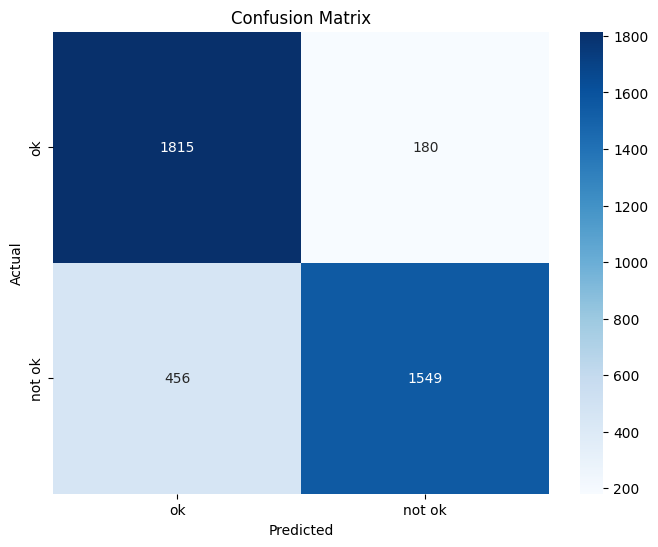

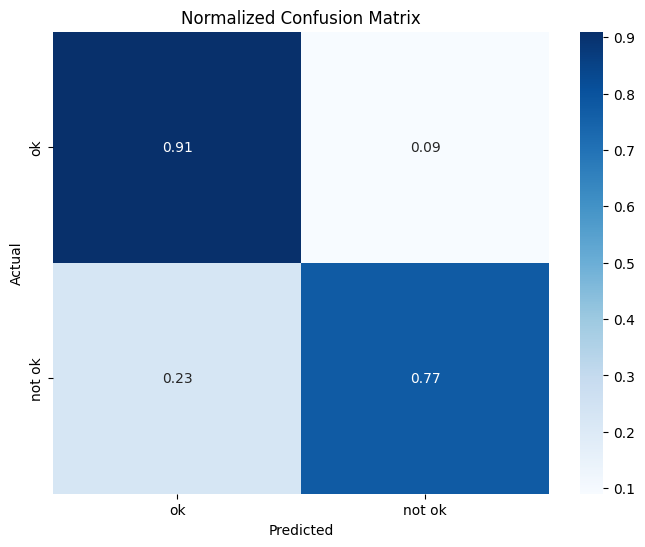

In [23]:
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

accuracy = accuracy_score(Ytest_id, preds)
recall = recall_score(Ytest_id, preds, average='macro')
F1 = 2*accuracy*recall/(accuracy + recall)
print("Test accuracy:", accuracy)
print("Test recall:", recall)
print("Test F1:",F1)

cm = confusion_matrix(Ytest_id, preds)
plt.figure(figsize=(8, 6))
if multi_class:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
else:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_binary, yticklabels=labels_binary)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 正規化したConfusion Matrix（各行を合計1に正規化）
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
if multi_class:
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
else:
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels_binary, yticklabels=labels_binary)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

In [24]:
# choosing sentence ramdomly, and see if it was correct or not
idx = random.randint(0, len(Xtest) - 1)
text = Xtest[idx]
true_label_id = Ytest_id[idx]
pred_label_id = preds[idx]

print("=== text that ramdomly choosed  ===")
print(text)

print("=== BoW Vector === ")
inspector.inspect(test_bows[idx])
print()

if(multi_class==True):
    print(f"\n[Inference Label] {labels[pred_label_id]} ({pred_label_id})")
    print(f"[Actual Label] {labels[true_label_id]} ({true_label_id})")
    print("→", "Correct" if true_label_id == pred_label_id else "Incorrect")
else:
    print(f"\n[Inference Label] {labels_binary[pred_label_id]} ({pred_label_id})")
    print(f"[Actual Label] {labels_binary[true_label_id]} ({true_label_id})")
    print("→", "Correct" if true_label_id == pred_label_id else "Incorrect")


print()


=== text that ramdomly choosed  ===
I am going to shove a burning torch up your ass. Then I will force you to sit on an open propane tank.
=== BoW Vector === 
you: 1 to: 2 a: 1 i: 2 your: 1 on: 1 an: 1 will: 1 am: 1 up: 1 ass: 1 then: 1 going: 1 open: 1 

[Inference Label] not ok (1)
[Actual Label] not ok (1)
→ Correct



## Experiment of changing the number of vocabulary

### Index for Multi Class Naive Bayes(BOW)

| Vocabulary Size | Test Accuracy | Test Recall | Test F1 |
|-----------------|---------------|-------------|---------|
| 50              | 0.56225       | 0.3100      | 0.3996  |
| 100             | 0.6165        | 0.3739      | 0.4655  |
| 1000            | 0.67225       | 0.4596      | 0.5460  |
| 10000           | 0.692         | 0.4670      | 0.5576  |

### Index for Multi Class Naive Bayes(TF-IDF)
Test accuracy: 0.68675
Test recall: 0.45533429912012663
Test F1: 0.5475967582457002

### Index for 2 Class Naive Bayes(BoW)
| Vocabulary Size | Test Accuracy | Test Recall | Test F1 |
|-----------------|--------------|-------------|---------|
| 50              | 0.7285       | 0.7285      | 0.7285  |
| 100             | 0.7840       | 0.7841      | 0.7841  |
| 1000            | 0.8410       | 0.8412      | 0.8411  |
| 10000           | 0.8735       | 0.8736      | 0.8735  |





## TF-IDF

Test accuracy: 0.8845
Test recall: 0.8844717779486122
Test F1: 0.8844858887491798


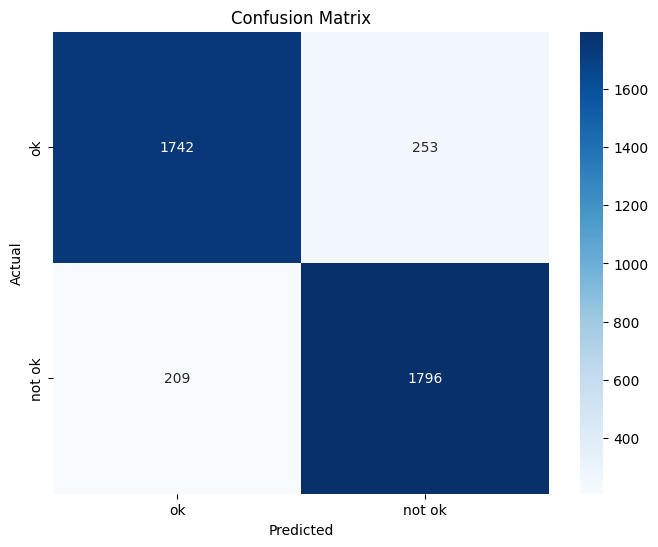

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
# テキストリスト Xtrain, Xtest をTF-IDFベクトルに変換
vectorizer = TfidfVectorizer(max_features=10000)  # 語彙数を指定
Xtrain_tfidf = vectorizer.fit_transform(Xtrain)
Xtest_tfidf = vectorizer.transform(Xtest)
model = MultinomialNB()
model.fit(Xtrain_tfidf, Ytrain_id)  # 学習
preds_tfidf = model.predict(Xtest_tfidf)  # 予測
accuracy = accuracy_score(Ytest_id, preds_tfidf)
recall = recall_score(Ytest_id, preds_tfidf, average='macro')
F1 = 2*accuracy*recall/(accuracy + recall)
print("Test accuracy:", accuracy)
print("Test recall:", recall)
print("Test F1:",F1)
cm = confusion_matrix(Ytest_id, preds_tfidf)
plt.figure(figsize=(8, 6))
if multi_class:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
else:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_binary, yticklabels=labels_binary)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()